This notebook implements Generative Adversarial Imitation Learning(Ho and Ermon, 2016) on the basic OpenAI Gym environmet of Acrobot-v1.

# Generative Adversarial Imitation Learning (GAIL)
## Introduction
I will make a brief introduction in the main components of reinforcement learning, as well as a short overview of imitation learning to make is more clear where GAIL can be situated and what is the motivation for it. 

Let's start with the basic tool to pose a reinforcement learning setting - the Markov Desicion Process(MDP). A MDP is a four-tuple $(S,A,P(s,a,s'), R(s,a,s'))$, where $S$ is the set of possible states, $A$ the state of possible action, $P(s,a,s')$ is the probability of transition in $s'$ after executing action $a$ when in state $s$, and $R(s,a,s')$ is the reward for this transtion. This way we can describe sequences of interactions with the environment under the use of the Markov property. The goal of the RL agent is to gather as much reward as possible in a long run. To achieve that in a sustainable way, the agent maintains a policy of what action to take when in a certain state. Mostly, we are interested in a stochastic policy - a function $\pi: S \to A$ in the form $\pi(a|s)$. This represents the distribution over actions of what is the right action to do in the current state. Follwoing its goal, the agent aims to learn 

Reinforcement learning problems are formalised as Markov Decision Process (MDP). This framework can fully describe the components and interactions in RL, where the sequence of decisions is chosen with respect to the long-term effect on the total accumulated reward and not to the immediate ones. Formaly, a MDP consists of a n-tuple $\{\mathcal{S}, \mathcal{A}, R, P, \gamma \}$. $\mathcal{S}$ is the set of some discrete states. They are representation of the current environment's state. Based on them, the agent takes decision to act, executing action from the  set of some discrete actions $\mathcal{A}$. The action sets the environment in a new state and responses with reward $R(s)$ for being at this state. P is the tensor of transitions probabilities $P(s,a,s') = p(s_{t+1}=s'|s_t=s, a_t=a)$, called also model of the environment, that fully specifies the outcome of taking action $a$ when in state $s$. When taking actions, the agent considers future rewards if might take along the way. How valuable these future rewards are for the current decision is  given by the discount factor $\gamma$. The policy $\pi(a|s)=Pr\{A_t=a|S_t=s\}$ expresses the preference of the agent for action $a$ when in state $s$. The final goal of the agent is to learn a policy that maximises the expected discounted return $G_t=\sum_i^T \gamma^i R_{t+i+1}$ from the current time step $t$ to the end of the episode at time $T$ (The same is true also for $T \to \infty$). The RL algorithms are focused in the task of finding this optimal policy $\pi^*$.

In imitation learning we might not have a reward function $R$, but additionally we have set of some demonstrations of desired(expert) behaviour, generated from an expert policy $\pi_E$. We need to formalize a optimization task for the agent to be able to learn from the demonstrated behaviour. One way is to do Behaviour cloning, where we directly learn a policy by minimizing the KL divergence with the expert policy:$
\pi^L = argmin_{\hat{\pi}\in\Pi}\mathbb{E}_{q(s,a)}\left[\ln\pi_E(a|s)-\ln\hat{\pi}(a|s)\right]    
$.
Here we seek for the policy $\hat{\pi}$ that is most similar to the expert policy. Learning directly the policy of the demonstrator is sub-optimal: small differences in the environment responses at test time can lead to significant errors - if the agent enters a unknown region, the following behaviour will be sub-optimal. We need some way to introduce ordering over all trajectories in the MDP.

With Inverse Reinforcement Learning (IRL) we try to learn the underlying reward/cost function $c \in C$ that can explain the observations. We assume that the expert has an optimal policy w.r.t. to this function and if uncover it, then the agent can learn the optimal policy and this way be able to become as good as the expert in this task. Because the idea of uses Maximum causal entropy IRL as a starting point, let's look at its objective:

$IRL(\pi_E)=max_{c \in C}(min_{\pi \in \Pi} -H(\pi) + \mathbb{E}_{\pi}[c(s,a)])-\mathbb{E}_{\pi_E}[c(s,a)]$

Maximum causal entropy IRL looks for a cost function $c \in C$ that assigns low cost to the samples from expert policy and high cost to other policies. Here for a given cost function, we try to minimise the expected cost w.r.t. a policy pi, while maintaining the entropy of the policy as high as possible. And then, with the obtained $\pi$, we try to maximise the difference between this term and the expected cost for the expert demonstrations by updating the cost function.

We will also need a brief idea of Generative adversarial networks (GAN). GANs are a class of generative models in which a generator is trained to optimize a cost function that is being simultaneously updated by a discriminator distribution. The generator generated a sample, while the discriminator assigns a score to the generated sample about its belief that the sample comes from a demonstration set $\mathcal{D}$. Thus, the discriminator's objective is:
    $\mathcal{L}(D) = \mathbb{E}_{x\sim \mathcal{D}} [-\log D(x)] + \mathbb{E}_{x\sim G} [-\log(1- D(x))]$.
The generator is optimized via the discriminator's confusion: 
$\mathcal{L}(G) = \mathbb{E}_{x\sim G} [-\log D(x)] + \mathbb{E}_{x\sim G} [\log(1- D(x))]$.
When the generator' loss becomes zero, this means that the discriminator is not able to decide where the sample comes from. In other words, the generator unveiled the underlying distribution of the demonstrations.

## Motivaion
Inverse Reniforcement Learning learns a cost function that explains the expert behaviour, but we still need to learn a policy after each change of the cost function. This is computationally expensive because we solve the RL problem in a inner loop again and again - for the objective above, we need to solve $RL(c)=argmin_{\pi \in \Pi} -H(\pi) + \mathbb{E}_{\pi}[c(s,a)]$. Then why to learn the cost function explicitly, if this doesn't tell the agent directly what to do? GAIL is one possible solution to learn a policy directly and avoid the intermediate IRL step. 


## The set of cost functions $C$
Now we are looking in the set $C$ of all possible functions $c$ to be sure that the cost function that explains the expert behaviour is among the solutions. If we choose to approximate the cost function with neural network, for example, to be able to cover as much functions as possible, we will need a regulariser to avoid overfitting. The new, regularised objective becomes: 

$IRL_{\psi}(\pi_E)=max_{c \in C} -\psi(c) +(min_{\pi \in \Pi} -H(\pi) + \mathbb{E}_{\pi}[c(s,a)])-\mathbb{E}_{\pi_E}[c(s,a)]$

While the policy can be approximates by any function, also non-convex one like NN, the authors propose the transformation from policies $\pi(a|s)$ to occupancy measures given by $\rho_{\pi}(s,a)= \pi(a|s) \sum_t \gamma^t P(s_t=s|\pi) $. When following a policy $\pi$, this is the distribution of state-action pairs that the agent will encounter. The expected cost for this policy is then given using the occupancy measure by $\mathbb{E}_{\pi}[c(s,a)]=\sum_{s,a} \rho_{\pi}(s,a)c(s,a)$.

Proposition 3.1 in the original paper shows that for $\pi_{\rho}$ is the only policy whose occupancy measure is $\rho$. Then we are allowed to re-write the cenrtal objective as follows:

$IRL_{\psi}(\pi_E)=max_{c \in C} -\psi(c) +(min_{\pi \in \Pi} -H(\pi) + \sum_{s,a} \rho_{\pi}(s,a)c(s,a))-\sum_{s,a} \rho_{\pi_E}(s,a)c(s,a)$


Moreover, Proposition 3.2 in the paper shows that using the convex conjugate of the regulariser with  $\rho_{\pi}-\rho_{\pi_E}$ gives us optimality guarantees that we can find a the optimal policy by optimising the $RL \circ IRL_{\psi}(\pi_E)$ problem directly:
$RL \circ IRL_{\psi}(\pi_E) = argmin_{\pi \in \Pi}-H(\pi)+\psi^*(\rho_{\pi} - \rho_{\pi_E})$ (Derived from the last equation and the definition of convex conjugate). The full proof relies on the fact that 

$L(\rho, c)= -\psi(c) -H(\pi) + \sum_{s,a} \rho_{\pi}(s,a)c(s,a))-\sum_{s,a} \rho_{\pi_E}(s,a)c(s,a)$

has a unique optimum $(\rho^*, c^*)$ for it is true that $c^* \in IRL_{\psi}(\pi_E)$ and $\pi^* \in RL \circ IRL_{\psi}(\pi_E)$ with $\pi_{\rho^*}=\pi^*$

The regularisation in this formulation becomes very important meaning - we can solve the Rl after IRL problem directly, because in this formulation we seek for a policy whose  occupancy measure is close to the expert’s, as measured by the convex function $\psi^*$. 

This observation becomes the central motivation of GAIL. 


## Using different kinds of $\Psi$
As we see, the form of the occupancy measure matching is crucial. If $\psi$ is a constant, meaning no regularisation, the optimisation problem turns to maximising the $-H(\pi)$, subject to $\rho_{\pi}(s,a) = \rho_{\pi_E}(s,a)$, for any state-action pair. This might be a huge space and it just doesn't scale to large environments. Here the cost of a state-action pair serves as dual variables. Of course, the expert behaviour does not include samples of all state-action pairs if the environment  is sufficiently large. This means that we need some other measure of the difference of occupancy measures. 
For this purpose we can use the proposition above, making the convex conjugate $\psi^*$ of the regularisation function the distance measure. For certain seatings of $\psi$, the objective gets the known objective of entropy-regularized apprenticeship learning, where the cost function is for example a linear combination of basis features: if we choose  $\psi(c)=\delta_C(c)$ where $\delta_C(c)=0$ if $c \in C$  and $\infty$ otherwise. This means 

$min_{\pi \in \Pi} -H(\pi) + max_{c \in C} \mathbb{E}_{\pi}[c(s,a)]-\mathbb{E}_{\pi_E}[c(s,a)] = min_{\pi \in \Pi} -H(\pi) + \delta^*_C(\rho_{\pi}-\rho_{\pi_E})$

For this case, there are existing algorithms, alternating between fitting the cost function to maximise the difference of the expected costs of simulated and expert trajectories. And in a second step update the policy with the current cost function. This method practically  scale to large environments. We will see that this is also the main idea behind the GAIL training. But if the true cost function $c^*$ is not in the set $C$ then the algorithm cannot recover the expert behaviour. The reason is given in the equation above - if $c^*$ in not in $C$, then is cannot be recovered by $RL \circ IRL_{\psi}(\pi_E)$, which will then not have an optimal solution for the policy.

## Regularisation with GAIL

This leads to the proposed form of the regulariser $\psi$. 
![title](psi.png)

First of all, it can adapt to the expert data.  But the exact choice of $\psi$ comes from the fact that the convex conjugate of psi for the occupancy matching is equal to the optimal negative log loss of a binary classifier that distinguishes between state acton pairs coming from the expert or from the current policy.

$\psi^*(\rho_{\pi} - \rho_{\pi_E}) = max \mathbb{E}_{\pi}[log(D(s,a))] + \mathbb{E}_{\pi_E}[log(1-D(s,a))]$

This is also the connection to Generative adversarial nets, where the discriminator has to distinguish between expert and generated data and the generator, that tries to generate examples that are indistinguishable for the discriminator from the expert examples.  Here we have the desired effect of avoiding to first learn a cost function, then a policy: as in GAN we gradually improve the examples generated by the policy until they are as good as the expert w.r.t. to a function with high capacity - in this case the discriminator is a neural network. 

!!! explain the generator and connect to PPO

## The algorithm
I'll not go into detail about trust region policy optimization, but it's simply an elaborated way updating the policy w.r.t. to the reward, as any policy gradient RL algorithm. For a fixed set of expert trajectories, we sample simulated trajectories with the current policy $\pi$ parametrized by $\theta$. In reality, we don't use whole trajectories of interactions, in order of appearance, but on a set of single interactions with the environment (state, action, reward, next state). Then we update the weights $\omega$ of the discriminator to distinguish between the expert and the simulated samples. Using the score that the discriminator assigned to the simulated trajectories as reward, we update the policy parameters with TRPO or proximal policy optimization (PPO). We continue until the discriminator cannot distinguish between expert and simulated samples.

![title](algo.png)


# Implementation 

## Requirements 



## The environment 
I implemented the algorithm and applied it on the open gym Acrobot-v1 environment. I couldn't applied on the previous version, used in the paper, which it is not supported anymore. But there aren't severe differences. The acrobot system includes two joints and two links, where the joint between the two links is controlled by the agent. The goal is to swing the end of the lower link above the line. For a visualisation, see the [original description](https://gym.openai.com/envs/Acrobot-v1/). The environment assignes a reward of -1 to every timestep. 

In [10]:
import gym
env = gym.make("Acrobot-v1")
env.seed(543)
env.reset()
for _ in range(100):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

2021-07-23 21:10:38.604 Python[57918:6358863] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/x8/b4pbrcf93mxbp34r940r0y440000gn/T/org.python.python.savedState


## Generator

I define the generator as a class. Its main purpose is to represent a policy with a neural network and be trained with PPO. The Generator class is mostly based on the [openai PPO implementation](https://github.com/openai/spinningup/tree/master/spinup/algos/pytorch/ppo). Since this is a big class with a lot of dependencies, I won't put them directly on this notebook. You can find it under generator.py. The main functionalities serve PPO, which is not in the scope of this project. 
The Generator maintains NN estimators for the policy and for the value function, since it is trained in Actor-Critic manner. These are packed in an object of the class core.MLPActorCritic. Each network has two hidden layers of 100 units an tanh activations, as pointed in the original paper. 
The Generator class has a ppo() method that is meant for training the policy. I updated it to also deal with the case where the reward where we generate interactions outside the method and apply the discriminator on them to obtain rewards, before starting PPO. I use the same method to train an expert for generating the expert demonstrations.

## Discriminator 

The discriminator receives a state-action pair from interaction sample and puts a score on it, representing the believe that this is a sample, generated from the policy instead of an expert sample. If use Binary Cross-Entropy between scores for policy samples and 1 as label and scores for expert samples and 0 as label, we reconstruct the proposed discriminator objective of the algorithm.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim


class Discriminator(nn.Module):
    """the discriminator class
    """
    def __init__(self, state_shape, hidden_shape=100, learning_rate=0.0002):

        super(Discriminator, self).__init__()
        input_shape = state_shape + 1
        self.main = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_shape, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=hidden_shape, out_features=hidden_shape, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=hidden_shape, out_features=1, bias=True), # final
        )
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, input):
        return self.main(input.float())

    def train(self, expert_trajectories, policy_trajectories):
        """train to distinguish expert from generated data
         Args:
            expert_trajectories (List)
            policy_trajectories ([type])
        Return:
            error, mean of the predicted score for expert samples and same for the generator samples
        """
        criterion = nn.BCEWithLogitsLoss()
        expert_output = torch.cat([self.forward(torch.cat((state, action))) 
                            for state, action in zip(expert_trajectories['state'], torch.unsqueeze(expert_trajectories['action'], 1))])
        policy_output = torch.cat([self.forward(torch.cat((state, action))) 
                            for state, action in zip(policy_trajectories['state'], torch.unsqueeze(policy_trajectories['action'], 1))])

        expert_labels = torch.zeros_like(expert_output, dtype=torch.float)
        policy_labels = torch.ones_like(policy_output, dtype=torch.float)

        errD_expert = criterion(expert_output, expert_labels)
        errD_policy = criterion(policy_output, policy_labels)

        errD_expert.backward()
        errD_policy.backward()

        errD = errD_expert + errD_policy
        self.optimizer.step()

        with torch.no_grad():
            expert_output = torch.sigmoid(expert_output)
            policy_output = torch.sigmoid(policy_output)

        return errD.item(), torch.mean(expert_output).item(), torch.mean(policy_output).item(), expert_output, policy_output
    

Let's initialize the main components and set some hyperparameters as in the paper:

In [51]:
from generator import Generator

EXPERT_TRAJECTORIES = 7 # how many expert trajectories to use
EXPERT_TRAJECTORIES_LIST = [1, 4, 7, 10] # (important for loading .json with expert demos)
GENERATOR_TIMESTEPS = 5000 # how many env interactions to gather before updating the policy
EXPERT_TRAIN_EPOCHS = 50 # when training the expert, how many epochs to learn
ITERATIONS = 20 # num of training iterations (step 2 in algorithm)
MAX_EP_LEN = 500 # if not done by MAX_EP_LEN, restart the environment for new episode
DISC_ITER = 0   # num iteration of pre-training only the discriminator 
DISC_L_RATE = 0.0002 # discriminator Adam learning rate

discriminator = Discriminator(state_shape=env.observation_space.shape[0], learning_rate=DISC_L_RATE)
generator = Generator(env, discriminator, max_ep_len=MAX_EP_LEN, steps_per_epoch=GENERATOR_TIMESTEPS)


Logging data to /tmp/experiments/1627068193/progress.txt

Number of parameters: 	 pi: 11103, 	 v: 10901



## Get demonstrations

To start the GAIL training, we first need expert demonstrations. For this purpose, we can train a policy with the original reward. Since the training takes a longer, I provide .json files with expert 1, 4, 7 and 10 expert trajectories, as used in the paper. The expert model is of class Generator, but it needs no Discriminator - it uses the -1 reward.  The method is also the same for generating policy demonstrations. If you really want to train a new model and get new expert trajectories, delete the .json files in the directory. This will trigger a training of an expert and generate files with 1,4,7 and 10 expert trajectories.

In [47]:
import datetime
import json_tricks

import utils

def get_demonstrations(env, expert=False):
    """get demonstrations from an expert/policy model

    Args:
        expert (bool, optional): [are these demonstrations from an expert]. Defaults to False.

    Returns:
        [torch.utils.data.DataLoader]: torch DataLoader object with the created data
    """
    env_name = env.spec.id
    if expert:
        try:
            with open(f'expert_{env_name}_demos_{EXPERT_TRAJECTORIES}.json', 'r') as fp:
                flat_trajectories = json_tricks.load(fp)
        except FileNotFoundError:
            model = Generator(env, None)
            model.ppo(epochs=EXPERT_TRAIN_EPOCHS)
            for num_trajectories in EXPERT_TRAJECTORIES_LIST:
                flat_trajectories = utils._generate_expert_demonstrations(model, env, num_trajectories)
                with open(f'expert_{env_name}_demos_{num_trajectories}.json', 'w') as fp:
                    json_tricks.dump(flat_trajectories, fp)
        return flat_trajectories
    if not expert:
        return utils._generate_policy_demonstrations(generator, env, GENERATOR_TIMESTEPS)

## Training 

Now we can proceed to training. We firts create a pytorch dataloader object with the expert state-action pairs to be able to shuffle them and create batches. After that, for each training iteration, we generate state-action pairs with the current policy (step 3 in the algorithm). Then we take a batch of the generated 5000 policy state-action pairs with batch size - the number of state-action pairs in the expert dataset. We train the discriminator with this data (step 4). After updating the discriminator, we apply on the policy generated state-action pairs to obtain the score and keep it as reward. Then we train the generator with the state-action pairs and the assigned reward (and the value from the critic network) (step 5).

Full learning with the default 300 iterations and 5000 policy state-action pairs takes around 20 minutes on a i7 processor.


In [48]:
def _assign_rewards(data):
    """assign discriminator scores to the generated trajectories  

    Args:
        data ([type]): trajectories
    """
    for sample in  data:
        with torch.no_grad(): 
            logits = discriminator.forward(
                torch.cat(
                    (
                        torch.as_tensor(sample['state'], dtype=torch.float32), 
                        torch.unsqueeze(torch.as_tensor(sample['action'], dtype=torch.float32),0)
                    )
                )
            )
            score = -torch.sigmoid(logits)
            sample['reward'] = score
    return data

In [52]:
import matplotlib.pyplot as plt

def train():
    """train alternating the discriminator and the generator

    Args:
        exp_demos ([type]): expert trajectories 
    """
    # for ploting
    disc_losses, expert_means, policy_means = [], [], []
    avg_ep_len, avg_rew_ep_len, probe_avg_ep_len = [], [], []
    batches, iterations = [], []
    rew_dev, expert_scores = [], []
    # disc_batch, gen_iter = 1, 1 
    # generate expert demonstrations
    expert_demos = get_demonstrations(env, expert=True)
    # get their avg episode length
    expert_avg_len = utils._expert_avg_len(expert_demos)
    # #! Using single batch
    expert_dataloader = utils.create_dataloader(expert_demos, None, expert=True)
    batch_size = expert_dataloader.dataset.__len__()
    # expert_dataloader = self.create_dataloader(expert_demos, BATCH_SIZE, expert=True)
    # batch_size = BATCH_SIZE
    for iteration in range(ITERATIONS):
        print(f'###########  Generating trajectories...  #########')
        gen_trajectories_flat, gen_pairs = get_demonstrations(env, expert=False)
        gen_dataloader = utils.create_dataloader(gen_trajectories_flat, batch_size, expert=False) 
        exp_data = next(iter(expert_dataloader))
        fake_data = next(iter(gen_dataloader)) #! train with fake single batch
        disc_loss, expert_mean, policy_mean, _, _ = discriminator.train(exp_data, fake_data) 
        print(f'Discriminator: loss: {disc_loss}\t expert mean {expert_mean} \t generator mean {policy_mean}')
        # for the plots:
        expert_means.append(expert_mean)
        policy_means.append(policy_mean)
        disc_losses.append(disc_loss)
        batches.append(iteration)

        # eventually, pretrain the discriinator; default is DISC_ITER = -1
        if iteration >= DISC_ITER:
            # apply the discriminator to get scores
            data = _assign_rewards(gen_pairs)

            # train the generator with all generator demonstrations
            generator.ppo(data=data)  

            # for the plots:   
            rew_stdcev, less_than_mean = utils._reward_statistics(data, expert_mean)
            rew_dev.append(rew_stdcev.item())
            expert_scores.append(less_than_mean)
            avg_ep_len.append(generator.avg_ep_len)
            iterations.append(iteration)
            print(f'------------ Iteration {iteration + 1} finished! ------------')

    utils._draw_gen_result(iterations, avg_ep_len, expert_avg_len, probe_avg_ep_len, avg_rew_ep_len)
    plt.show()
    utils._draw_disc_result(batches, policy_means, expert_means, disc_losses)
    plt.show()
    utils._draw_score_statitics(iterations, rew_dev, expert_scores)
    plt.show()

###########  Generating trajectories...  #########
Discriminator: loss: 1.3932169675827026	 expert mean 0.4999346435070038 	 generator mean 0.5052554607391357
---------------------------------------
|             EpLen |             500 |
|             Epoch |               0 |
|      AverageEpRet |            -254 |
|          StdEpRet |             1.8 |
|          MaxEpRet |            -253 |
|          MinEpRet |            -257 |
|      AverageVVals |          0.0387 |
|          StdVVals |          0.0346 |
|          MaxVVals |           0.199 |
|          MinVVals |         -0.0288 |
| TotalEnvInteracts |           5e+03 |
|            LossPi |        1.59e-07 |
|             LossV |        1.83e+03 |
|       DeltaLossPi |        -0.00848 |
|        DeltaLossV |            -901 |
|           Entropy |            1.09 |
|                KL |           0.009 |
|          ClipFrac |           0.105 |
|          StopIter |              79 |
|              Time |            1.52 |
-

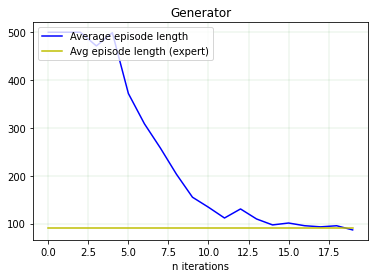

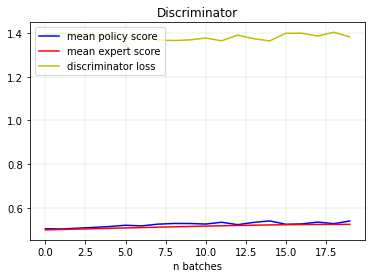

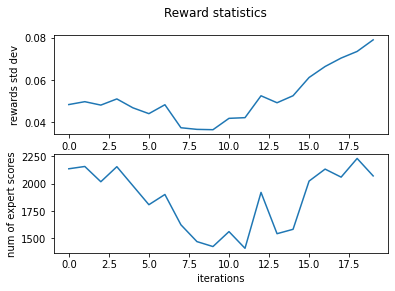

In [53]:
train()

# Results

The performance measure for this environment is the lenght of the episode - shorter episodes are better, reaching the goal in less timesteps. 

In this section I'll report observations over different configurations for training. I use the default hyperparameters of 300 training iterations with 5000 state-action values per iteration, generated with the policy. Overall, the implementation is able to recreate the results, reported in the paper for this environment, reaching constantly episode lenghts of 80 and below down to 65 steps. The comparison is done with the average episode length of the expert trajectories. For 1, 4, 7 or 10 expert trajectories in the dataset, the agent is at least as good as the expert after 300 iterations. Here with 7 expert trajectories:

![title](plots/generator_7.png)

The behaviour of the discriminator is also as expected: the mean of the scores for expert and policy state-action pairs starts at 0.5 for both, as the discriminator is initialized at random. Then after the first batch of state-action pairs the policy score starts to grow. The loss falls for a little while accordingly. But as we can see from the generator performance, it very fast starts to generate trajectories that are close to expert - its performance is on expert level after just 20 iterations. Then the discriminator starts making mistakes and the expert scores grow instead of falling - it takes them for policy generations. Eventually, the loss oscillates a little, but we can see that both averages are very close. GAN are having trouble with exploding gradients and unstable losses, but it doesn't compromise the performance of the generator, it was shown. In our case it is the same. But we see that with time the discriminator scores go arround 0.5 as expected, showing no preference to any of policy or expert.

![title](plots/discriminator_7.png)

GAIL is also learning faster than a policy, initilialized with the same parameters, but optimized with the original reward of -1 per step. Here is a comparison at the early stages of training: 

![title](plots/probe_generator_iter_10_19:54:31_Jul_23_.png)

We can also ask why is the new reward better than simply using -1. The next figure shows two aspects of the reward signal coming from the discriminator. First, the standard deviation of the rewards shows that the rewards get rapidly more differentiated at the begining of the training. This means that very soon after start, the policy receives elaborated feedback for any state-action pair, which is more helpful than the same feedback of -1 for all state-action pairs. This deviation grows, besides the oscillations, and then starts falling again, as more and more state-action pairs are undistinguishable from the expert. In the lower figure you can see how many of all scores are below the average of the expert score, meaning can be seen as predicted to come from expert. We see that they also grow in overall, at the beginning. 

![title](plots/reward_7.png)

The results above are from the algorithm applied as in the paper. I did some variations of the configurations and found the results confirmed. But in one setting they are even more 'clear' - when the discriminator is pretrained for 30 iterations before training the policy. I found it useful, because the policy seems to learn very fast, so the discriminator doesn't really learn a clear distinction between expert and policy. Apparently, it is capable of this, but just needs some time:

![title](plots/pretrained_discriminator_iter_7_08:23:16_Jul_22_.png)
 
The loss clearly falls down, but after the first time the generator also gets trained, it rapidly grows again. I find this as a signal of how fast the policy is learning behaviour close to expert. The discriminator is still more stable, probably because also the generator is more stable, since it received more elaborated feedback at the beginning. 

![title](plots/pretrained_generator_iter_7_08:22:51_Jul_22_.png)


This is also visible in the tendancy of the rewards. Here std. dev. and number of scores below average expert score are measured after the 30 iterations of pretraining. The discriminator is able to rightly predict that all initial state-action pairs from the policy are fake, so the std. dev. is low - they all get high scores. Also the number of such pairs that are in the expert score scale is close to 0. Then the tendency rapidly grows, and as the policy becomes as good as the expert, the std. dev. of the scores falls again. The discriminator rightly predicts around the half of the 5000 pairs as expert - it cannot distinguish them anymore.

![title](plots/pretrained_rewards_iter_7_08:23:25_Jul_22_.png)


# Conclusion

Generative adversarial imitation learning showed robust performance on Acrobot, a classic gym environemnt. It is able to learn fast even from a small set of very demonstrations. 